In [2]:
import numpy as np
import pandas as pd
from scipy.signal import correlate
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
from scipy.optimize import dual_annealing, minimize

In [3]:

df_eye_all = pd.read_csv('processed_data\processed_data_asc_task_sacccades_all_post_process_indiv.csv')
df_cam_all = pd.read_csv('processed_data\processed_data_tiny_task_sacccades_all_post_process_indiv.csv')


In [4]:


def find_optimal_transformation(X_tiny, X_eyelink, grid_size=100, scale_N=2, shift_N=3):
    """
    Find optimal scale and shift to transform X_tiny to match X_eyelink using dual annealing
    followed by gradient descent fine-tuning. Warns if optimal values are at boundaries.
    Handles positive and negative mean_diff for shift_range.
    
    Parameters:
    X_tiny: numpy array, input data to be transformed
    X_eyelink: numpy array, target data
    grid_size: int, number of points for range definition (used for bounds)
    scale_N: float, multiplier for scale range
    shift_N: float, multiplier for shift range
    
    Returns:
    best_scale, best_shift: optimal transformation parameters
    """
    
    # Define ranges for bounds
    scale_range = np.linspace(np.std(X_eyelink)/(scale_N*np.std(X_tiny)),
                             scale_N*np.std(X_eyelink)/np.std(X_tiny), grid_size)
    
    reverse_scaling = np.std(X_tiny)/np.std(X_eyelink)
    mean_diff = np.mean(X_eyelink) - np.mean(X_tiny)/reverse_scaling
    
    print(f"Reverse scaling: {reverse_scaling:.4f}")
    print(f"Mean difference: {mean_diff:.4f}")
    
    # Define shift_range, handling positive and negative mean_diff
    epsilon = 1e-6
    if mean_diff == 0:
        shift_range = np.linspace(-epsilon, epsilon, grid_size)
    else:
        center = reverse_scaling * mean_diff
        width = reverse_scaling * abs(mean_diff) * shift_N
        shift_range = np.linspace(center - width, center + width, grid_size)

    # Define bounds for dual annealing
    bounds = [(scale_range[0], scale_range[-1]), (shift_range[0], shift_range[-1])]
    
    # Objective function: MSE between transformed X_tiny and X_eyelink
    def objective(params):
        scale, shift = params
        transformed = scale * (X_tiny + shift)
        return np.mean((transformed - X_eyelink) ** 2)
    
    # Run dual annealing
    result = dual_annealing(objective, bounds, seed=42)
    best_scale, best_shift = result.x
    
    # Check if optimal values are at boundaries
    if np.isclose(best_scale, scale_range[0]) or np.isclose(best_scale, scale_range[-1]):
        print(f"Warning: Optimal scale ({best_scale:.4f}) is at the boundary of the grid "
              f"(range: [{scale_range[0]:.4f}, {scale_range[-1]:.4f}]). "
              "Consider increasing the scale_N or grid_size.")
    if np.isclose(best_shift, shift_range[0]) or np.isclose(best_shift, shift_range[-1]):
        print(f"Warning: Optimal shift ({best_shift:.4f}) is at the boundary of the grid "
              f"(range: [{shift_range[0]:.4f}, {shift_range[-1]:.4f}]). "
              "Consider increasing the shift_N or grid_size.")
    
    # Gradient descent fine-tuning using BFGS
    result = minimize(objective, x0=[best_scale, best_shift], method='BFGS')
    best_scale, best_shift = result.x
    
    return best_scale, best_shift



PID P006 → global lag = 89.0 ms
Reverse scaling: 1.1691
Mean difference: 317.4343
Participant; P006, Optimal scale: 0.7453, Optimal shift: 560.2789
PID P008 → global lag = 104.0 ms
Reverse scaling: 0.6028
Mean difference: -1083.0792
Participant; P008, Optimal scale: 1.5880, Optimal shift: -624.8060
PID P020 → global lag = 83.0 ms
Reverse scaling: 1.2009
Mean difference: 199.5875
Participant; P020, Optimal scale: 0.8238, Optimal shift: 251.7053
PID P036 → global lag = 71.0 ms
Reverse scaling: 1.3122
Mean difference: 260.2488
Participant; P036, Optimal scale: 0.7533, Optimal shift: 355.9682
PID P063 → global lag = 72.0 ms
Reverse scaling: 1.2056
Mean difference: 265.8289
Participant; P063, Optimal scale: 0.8039, Optimal shift: 358.1775
PID P070 → global lag = 53.0 ms
Reverse scaling: 1.2069
Mean difference: 271.8072
Participant; P070, Optimal scale: 0.8120, Optimal shift: 353.9039
PID P072 → global lag = 69.0 ms
Reverse scaling: 1.1485
Mean difference: 188.0825
Participant; P072, Optimal

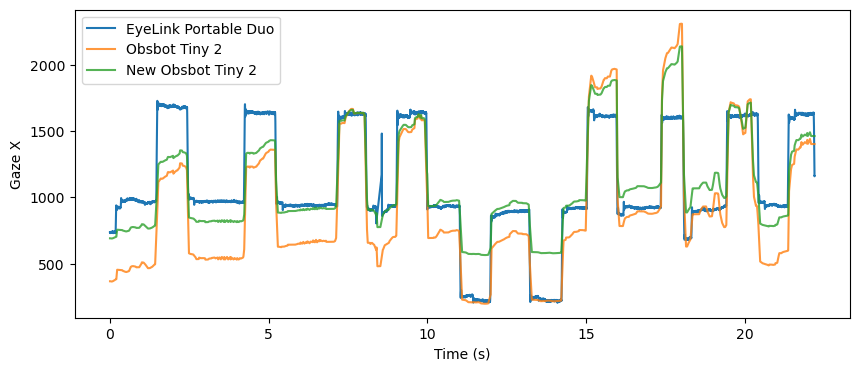

In [5]:

df_eye_all = pd.read_csv('processed_data\processed_data_asc_task_sacccades_all_post_process_indiv.csv')
df_cam_all = pd.read_csv('processed_data\processed_data_tiny_task_sacccades_all_post_process_indiv.csv')

df_eye_all.rename(columns={'Time': 'time', 'RX_': 'x', 'RY_': 'y', 'participants': 'participant'}, inplace=True)
df_cam_all.rename(columns={'eyelink_time': 'time', 'post_calX': 'x', 'participants': 'participant'}, inplace=True)

# compute each participant’s eye‐start and subtract from both streams
df_eye_all['t0_ms'] = df_eye_all.groupby('participant')['time'].transform('first')
df_eye_all['t_ms0'] = df_eye_all['time'] - df_eye_all['t0_ms']

t0_df = df_eye_all[['participant','t0_ms']].drop_duplicates()
df_cam_all = df_cam_all.merge(t0_df, on='participant', how='left')
df_cam_all['t_ms0'] = df_cam_all['time'] - df_cam_all['t0_ms']


# CLEAN + GLOBAL‐LAG FUNCTION (ms)
def clean_and_estimate_global_lag_ms(eye_df, cam_df,
                                     max_interp_gap_ms=300,
                                     max_search_ms=500):
    # eye time grid & sampling interval
    t_eye = eye_df['t_ms0'].values
    dt = np.median(np.diff(t_eye))                 
    # max_gap_samps = max(1, int(max_interp_gap_ms / dt))

    df = eye_df.copy()
    df['x_imputed'] = df['x'].interpolate(
        method='linear',  limit_direction='both'
    )
    good = np.isfinite(df['x_imputed'])
    df['good_mask'] = good

    #  raw start‐time offset (ms)
    raw_offset = cam_df['t_ms0'].iloc[0] - eye_df['t_ms0'].iloc[0]
    t_cam_aligned = cam_df['t_ms0'].values - raw_offset

    # interpolate cam.x onto the eye time grid
    x_cam_on_t = np.interp(t_eye, t_cam_aligned, cam_df['x'].values)

    # Build a mask of valid (finite) samples in both streams
    good_eye = np.isfinite(eye_df['x'].values)
    good_cam = np.isfinite(x_cam_on_t)
    good     = good_eye & good_cam
    if good.sum() < 2:
        raise ValueError("Not enough overlapping valid samples to estimate lag.")

    # Cross-correlate over only the “good” points, restricted to ±max_search_ms
    xr = eye_df['x'].values[good]
    xc = x_cam_on_t[good]
    xr = xr - xr.mean()
    xc = xc - xc.mean()

    cc    = correlate(xc, xr, mode='full', method='direct')
    lags  = np.arange(-len(xc)+1, len(xr))
    max_p = int(max_search_ms / dt)
    valid = np.abs(lags) <= max_p

    best   = lags[valid][np.argmax(cc[valid])]
    lag_ms = best * dt
    return df, lag_ms


# LOCAL‐WARP FUNCTION (seconds)
def align_by_local_correlation(t_ref, x_ref, t_cam, x_cam,
                               window_sec=2.0, step_sec=0.5,
                               max_lag_sec=0.5, smooth_spline_s=1e-2,
                               spline_k=3, min_samples_per_win=10):
    """
    Time‐warp camera timestamps to match reference.
    """
    # sliding‐window centers
    t0, t1 = t_ref[0], t_ref[-1]
    centers = np.arange(t0 + window_sec/2,
                        t1 - window_sec/2 + 1e-8,
                        step_sec)
    center_list, lag_list = [], []

    for tc in centers:
        w0, w1 = tc - window_sec/2, tc + window_sec/2
        mask_ref = (t_ref>=w0)&(t_ref<=w1)
        mask_cam = (t_cam>=w0-max_lag_sec)&(t_cam<=w1+max_lag_sec)

        xr = x_ref[mask_ref]; tr = t_ref[mask_ref]
        xc = x_cam[mask_cam]; tc_sub = t_cam[mask_cam]
        if len(xr)<min_samples_per_win or len(xc)<min_samples_per_win:
            continue

        N = max(len(xr), len(xc), 200)
        uni_t = np.linspace(w0, w1, N)
        xr_u = np.interp(uni_t, tr, xr)
        xc_u = np.interp(uni_t, tc_sub, xc)

        max_pts = int(max_lag_sec / (uni_t[1]-uni_t[0]))
        cc = correlate(xc_u - xc_u.mean(),
                       xr_u - xr_u.mean(),
                       mode='full')
        lags_pts = np.arange(-len(xc_u)+1, len(xr_u))
        valid = np.abs(lags_pts) <= max_pts
        lags_sub, cc_sub = lags_pts[valid], cc[valid]
        best = lags_sub[np.argmax(cc_sub)]
        lag_sec = best * (uni_t[1]-uni_t[0])

        center_list.append(tc)
        lag_list.append(lag_sec)

    centers = np.array(center_list); lags = np.array(lag_list)
    if len(lags) <= 1:
        const = float(lags[0]) if len(lags)==1 else 0.0
        lag_fn = lambda t: const
    else:
        k_fit = min(spline_k, len(lags)-1)
        lag_fn = UnivariateSpline(centers, lags, k=k_fit, s=smooth_spline_s)

    t_cam_corr = t_cam - lag_fn(t_cam)
    return t_cam_corr, lag_fn



aligned_results = []

# per participant
for pid in df_eye_all['participant'].unique():
    eye = df_eye_all[df_eye_all.participant==pid].reset_index(drop=True)
    cam = df_cam_all[df_cam_all.participant==pid].reset_index(drop=True)
    if cam.empty:
        print(f"PID {pid}: no camera data, skipping.")
        continue

    # clean + compute refined global lag (ms)
    eye_clean, lag_ms = clean_and_estimate_global_lag_ms(eye, cam)
    print(f"PID {pid} → global lag = {lag_ms:.1f} ms")

    # apply constant shift & convert to seconds
    cam['t_shifted_s'] = (cam['t_ms0'] - lag_ms) / 1000.0
    t_ref = eye_clean['t_ms0'].values / 1000.0
    x_ref = eye_clean['x_imputed'].values
    t_cam = cam['t_shifted_s'].values
    x_cam = cam['x'].values

    # fine align using local correlation
    t_cam_corr, lag_fn = align_by_local_correlation(
        t_ref, x_ref, t_cam, x_cam,
        window_sec=1.8, step_sec=0.5, max_lag_sec=0.5, smooth_spline_s=1e-2
    )

    # interpolate tiny camera signals onto eyelink time grid
    eye_clean['x_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['x'].values)
    # eye_clean['y_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['y'].values)

    # use grid search to find the optimal scale and shift
    optimal_scale, optimal_shift = find_optimal_transformation(np.array(eye_clean['x_cam_aligned']), np.array(eye_clean['x_imputed']) ,grid_size=100, scale_N=2, shift_N=5)
    print(f"Participant; {pid}, Optimal scale: {optimal_scale:.4f}, Optimal shift: {optimal_shift:.4f}")
    
    # apply the optimal scale and shift to tiny data
    eye_clean['new_tinyX'] = optimal_scale * (np.array(eye_clean['x_cam_aligned'].values) + optimal_shift)

    aligned_results.append({
        'participant': pid,
        'eye_aligned_df': eye_clean,
        'cam_aligned_df': cam.assign(t_cam_corr_s=t_cam_corr),
        'global_lag_ms': lag_ms,
        'lag_fn': lag_fn
    })

all_aligned = pd.concat(
    [res['eye_aligned_df'] for res in aligned_results],
    ignore_index=True
)

res0 = aligned_results[0]
eye0 = res0['eye_aligned_df']
plt.figure(figsize=(10,4))
plt.plot(eye0['t_ms0']/1000.0, eye0['x_imputed'],      label='EyeLink Portable Duo')
plt.plot(eye0['t_ms0']/1000.0, eye0['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
plt.plot(eye0['t_ms0']/1000.0, eye0['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
plt.xlabel('Time (s)'); plt.ylabel('Gaze X'); plt.legend(); plt.show()


In [7]:
# eleminating participant P065 at index 5
# del aligned_results[5]

In [8]:
task_data_df = []
for i in range(len(aligned_results)):
    for data in aligned_results[i]['eye_aligned_df'].groupby('interval_num'):
        task_data_df.append(data[1])

In [9]:
task_data_df[0]

,time,RX,RY,state,participant,time_delay,X,Y,interval_num,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX
0,50603116.0,737.7,364.9,0.0,P006,1.3,0.65,0,1,737.7,364.9,50603116.0,0.0,737.7,True,368.088121,691.915179
1,50603117.0,738.1,364.4,0.0,P006,1.3,0.65,0,1,738.1,364.4,50603116.0,1.0,738.1,True,368.175836,691.980554
2,50603118.0,738.0,366.5,0.0,P006,1.3,0.65,0,1,738.0,366.5,50603116.0,2.0,738.0,True,368.263551,692.045928
3,50603119.0,735.4,368.7,0.0,P006,1.3,0.65,0,1,735.4,368.7,50603116.0,3.0,735.4,True,368.351266,692.111302
4,50603120.0,732.9,367.5,0.0,P006,1.3,0.65,0,1,732.9,367.5,50603116.0,4.0,732.9,True,368.438980,692.176676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297,50605413.0,1679.5,607.7,1.0,P006,1.3,0.65,0,1,1679.5,607.7,50603116.0,2297.0,1679.5,True,1239.650950,1341.493969
2298,50605414.0,1675.2,607.6,1.0,P006,1.3,0.65,0,1,1675.2,607.6,50603116.0,2298.0,1675.2,True,1239.622707,1341.472919
2299,50605415.0,1673.9,605.9,1.0,P006,1.3,0.65,0,1,1673.9,605.9,50603116.0,2299.0,1673.9,True,1239.594464,1341.451870
2300,50605416.0,1673.9,604.1,1.0,P006,1.3,0.65,0,1,1673.9,604.1,50603116.0,2300.0,1673.9,True,1239.566221,1341.430820


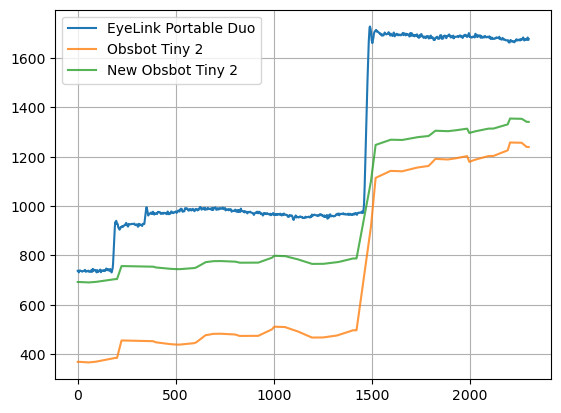

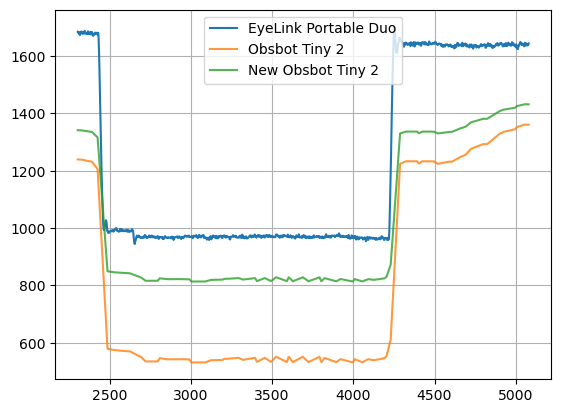

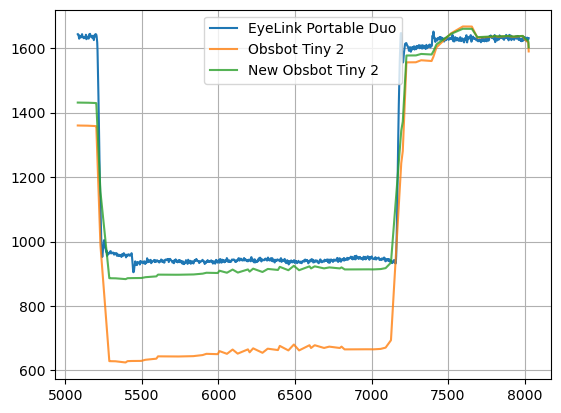

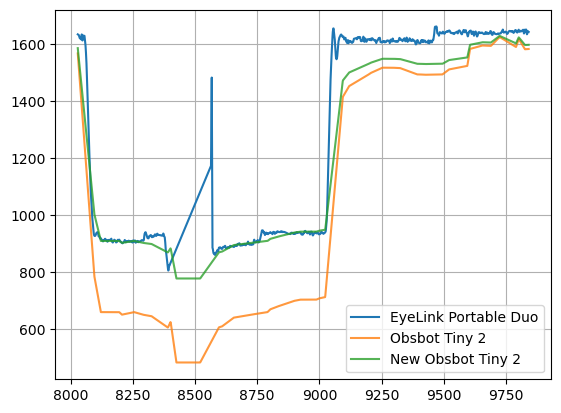

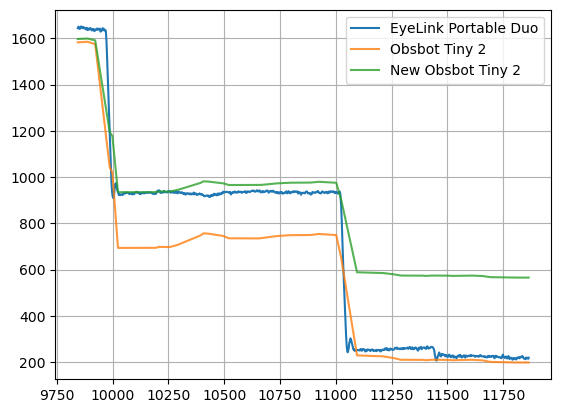

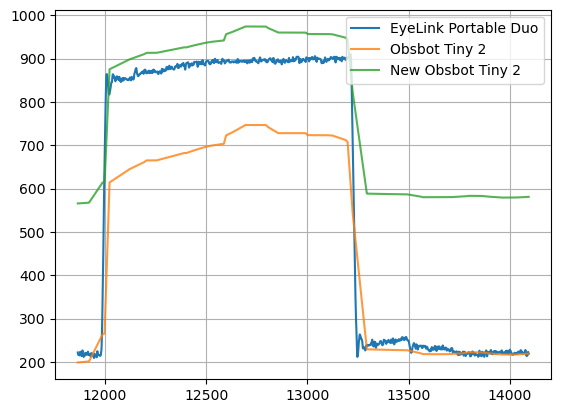

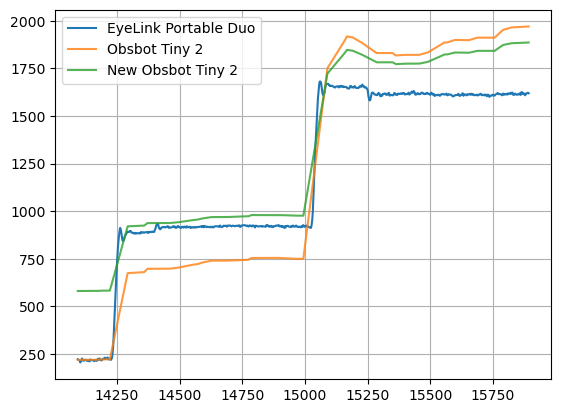

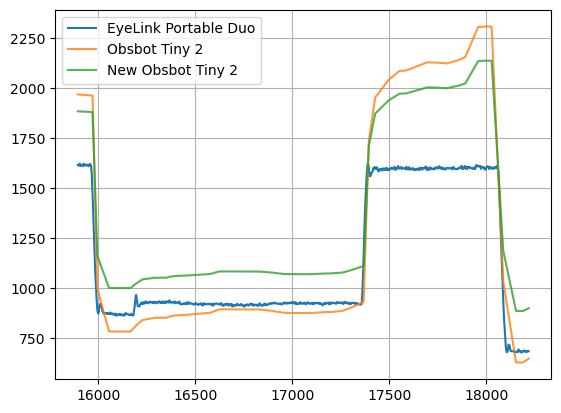

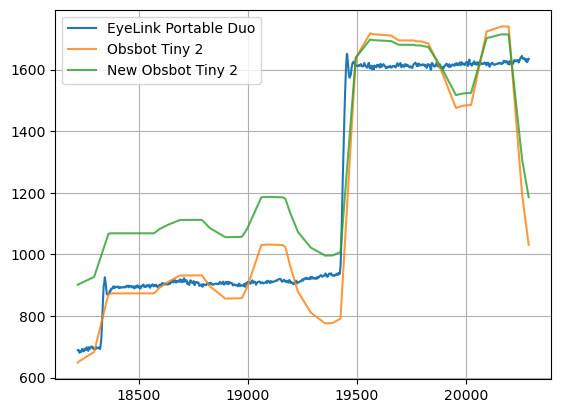

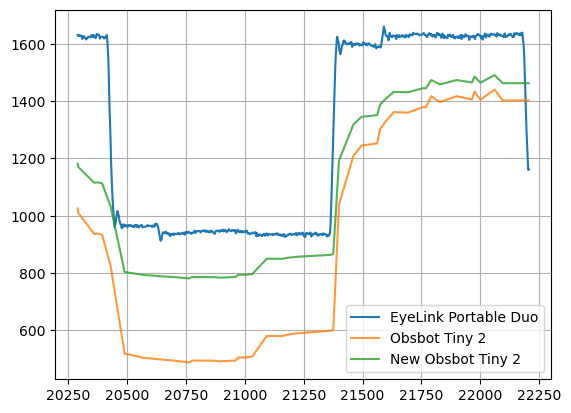

In [10]:
for i in range(10):
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_imputed'], label='EyeLink Portable Duo')
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
    plt.grid(True)
    plt.legend()
    plt.show()

In [12]:
reaction_time_saccade_asc = []
reaction_time_saccade_tiny = []
countnan = 0


for i in range(len(task_data_df)):
    task_data_df[i] = task_data_df[i].reset_index(drop=True)
    starting_time = task_data_df[i]['t_ms0'].min()
    time_offset_ms = float(task_data_df[i].time_delay[0]) * 1000  # Convert seconds to milliseconds

    index_to_highlight = (task_data_df[i]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()


    saccade_start_saccade_asc_1 =np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],len(task_data_df[i])-index_to_highlight)
    saccade_start_saccade_asc_2 = np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],len(task_data_df[i])-index_to_highlight)
    saccade_start_saccade_asc = np.min(np.hstack([saccade_start_saccade_asc_1,saccade_start_saccade_asc_2]))
    reaction_time_saccade_asc.append(saccade_start_saccade_asc)

    if len(saccade_start_saccade_asc_1)>1 and len(saccade_start_saccade_asc_2)>1:
        print('asc',i)

    
    saccade_start_saccade_tiny_1 =np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] > 1344 )[0],len(task_data_df[i])-index_to_highlight)
    saccade_start_saccade_tiny_2 = np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] < 576 )[0],len(task_data_df[i])-index_to_highlight)
    saccade_start_saccade_tiny = np.min(np.hstack([saccade_start_saccade_tiny_1,saccade_start_saccade_tiny_2]))
    reaction_time_saccade_tiny.append(saccade_start_saccade_tiny)

    if len(saccade_start_saccade_tiny_1)>1 and len(saccade_start_saccade_tiny_2)>1:
        print('tiny',i)

    

asc 44
tiny 44
tiny 157
asc 203
tiny 203
asc 213
tiny 213
asc 314
tiny 314
asc 324
tiny 324


In [ ]:
reaction_time_saccade_asc = []
reaction_time_saccade_tiny = []
countnan = 0


for i in range(len(task_data_df)):
    # if i == 3:

    task_data_df[i] = task_data_df[i].reset_index(drop=True)
    starting_time = task_data_df[i]['t_ms0'].min()
    time_offset_ms = float(task_data_df[i].time_delay[0]) * 1000  # Convert seconds to milliseconds

    index_to_highlight = (task_data_df[i]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()

    saccade_start_saccade_asc_1 =np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_asc_2 = np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_asc = np.min(np.hstack([saccade_start_saccade_asc_1,saccade_start_saccade_asc_2]))
    
    saccade_start_saccade_tiny_1 =np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_tiny_2 = np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_tiny = np.min(np.hstack([saccade_start_saccade_tiny_1,saccade_start_saccade_tiny_2]))

    if (saccade_start_saccade_asc < 10000) and (saccade_start_saccade_asc > 0) and (saccade_start_saccade_tiny > 0) and (saccade_start_saccade_tiny < 10000):
        reaction_time_saccade_asc.append(saccade_start_saccade_asc)
        reaction_time_saccade_tiny.append(saccade_start_saccade_tiny)

In [14]:
len(reaction_time_saccade_asc)

358

In [15]:
len(reaction_time_saccade_tiny)

358

In [29]:
reaction_time_saccade_tiny

[900,
 570,
 172,
 240,
 417,
 148,
 164,
 174,
 294,
 194,
 195,
 229,
 237,
 268,
 236,
 213,
 217,
 235,
 196,
 191,
 203,
 226,
 177,
 190,
 191,
 191,
 203,
 197,
 202,
 229,
 210,
 207,
 246,
 173,
 221,
 206,
 186,
 187,
 192,
 231,
 212,
 193,
 228,
 247,
 201,
 259,
 209,
 252,
 264,
 151,
 143,
 363,
 171,
 225,
 178,
 157,
 401,
 205,
 282,
 209,
 241,
 248,
 225,
 202,
 211,
 204,
 212,
 269,
 175,
 158,
 161,
 170,
 179,
 163,
 149,
 166,
 171,
 156,
 231,
 146,
 192,
 203,
 250,
 245,
 228,
 259,
 195,
 219,
 312,
 175,
 191,
 194,
 264,
 248,
 235,
 224,
 250,
 178,
 270,
 192,
 180,
 249,
 189,
 218,
 217,
 208,
 191,
 272,
 430,
 232,
 268,
 230,
 274,
 240,
 274,
 439,
 212,
 322,
 251,
 268,
 264,
 317,
 282,
 219,
 259,
 242,
 228,
 155,
 202,
 253,
 224,
 207,
 200,
 166,
 182,
 199,
 181,
 200,
 216,
 267,
 275,
 188,
 200,
 163,
 182,
 193,
 224,
 131,
 244,
 228,
 155,
 214,
 185,
 153,
 178,
 226,
 245,
 215,
 208,
 193,
 235,
 219,
 239,
 187,
 247,
 172,
 192

In [31]:
with open('./Plots and Files/saccade_task/reaction_time_saccade_eyelink.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in reaction_time_saccade_asc)

with open('./Plots and Files/saccade_task/reaction_time_saccade_tiny.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in reaction_time_saccade_tiny)

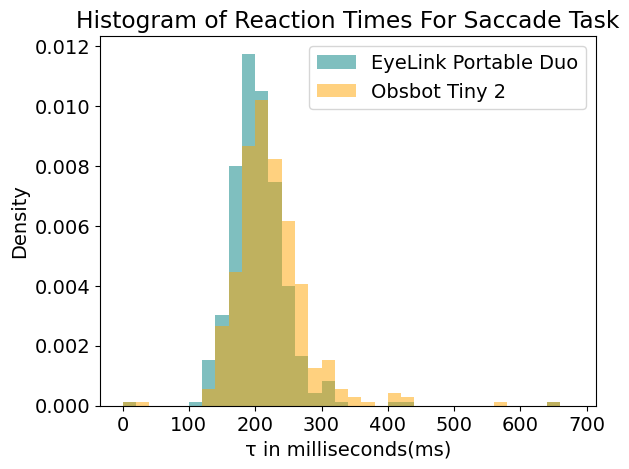

In [30]:
matplotlib.rcParams.update({'font.size':14})

plt.hist(reaction_time_saccade_asc, np.arange(0,700,20), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
plt.hist(reaction_time_saccade_tiny, np.arange(0,700,20), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel('\N{GREEK SMALL LETTER TAU} in milliseconds(ms)')
plt.title('Histogram of Reaction Times For Saccade Task')
plt.legend()
plt.show()

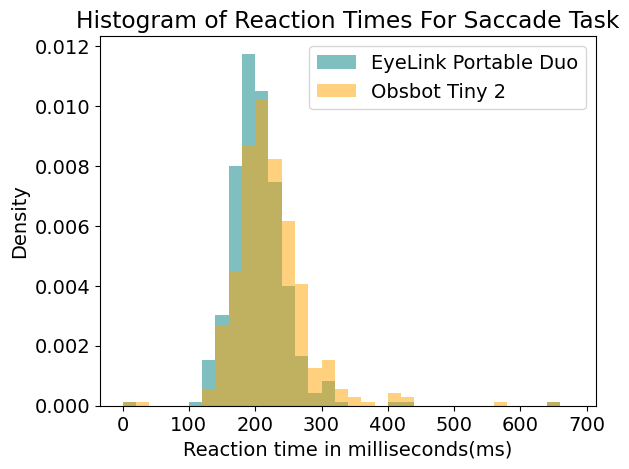

<Figure size 640x480 with 0 Axes>

In [33]:
matplotlib.rcParams.update({'font.size':14})

plt.hist(reaction_time_saccade_asc, np.arange(0,700,20), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
plt.hist(reaction_time_saccade_tiny, np.arange(0,700,20), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel('Reaction time in milliseconds(ms)')
plt.title('Histogram of Reaction Times For Saccade Task')
plt.legend()
plt.show()
plt.tight_layout()



In [19]:
def to_quantiles(arr):
    """
    Transform an array so each value is replaced by its quantile in the distribution.
    
    Parameters:
    arr: numpy array, input data to be transformed
    
    Returns:
    quantiles: numpy array, quantile values (between 0 and 1) corresponding to each input value
    """
    # Convert input to numpy array
    arr = np.asarray(arr)
    
    # Get ranks (using 'average' method for ties)
    ranks = np.argsort(np.argsort(arr, kind='mergesort'))  # Stable sort for consistency
    n = len(arr)
    
    # Convert ranks to quantiles: (rank + 0.5) / n for centered quantiles
    quantiles = (ranks + 0.5) / n
    
    return quantiles

In [20]:
q = to_quantiles(reaction_time_saccade_asc)
q

array([0.18296089, 0.11871508, 0.06284916, 0.5349162 , 0.16620112,
       0.05167598, 0.09078212, 0.05446927, 0.23603352, 0.49301676,
       0.32541899, 0.72486034, 0.83379888, 0.93994413, 0.63826816,
       0.55167598, 0.64106145, 0.84776536, 0.50698324, 0.30307263,
       0.25558659, 0.34497207, 0.22206704, 0.19413408, 0.31145251,
       0.45391061, 0.41759777, 0.35614525, 0.21089385, 0.24441341,
       0.45670391, 0.45949721, 0.69413408, 0.14385475, 0.55446927,
       0.43435754, 0.14944134, 0.28631285, 0.2472067 , 0.61592179,
       0.39804469, 0.23882682, 0.58519553, 0.73044693, 0.27234637,
       0.73324022, 0.35893855, 0.81424581, 0.8924581 , 0.05726257,
       0.02653631, 0.55726257, 0.09916201, 0.75      , 0.14664804,
       0.07681564, 0.32821229, 0.34776536, 0.95670391, 0.47625698,
       0.7527933 , 0.82821229, 0.74441341, 0.33100559, 0.28910615,
       0.24162011, 0.46787709, 0.88407821, 0.06564246, 0.06843575,
       0.13547486, 0.10195531, 0.1047486 , 0.04888268, 0.01536

In [21]:
r = to_quantiles(reaction_time_saccade_tiny)
r

array([0.99860335, 0.99301676, 0.1075419 , 0.69972067, 0.98184358,
       0.02932961, 0.07960894, 0.11871508, 0.92039106, 0.28072626,
       0.29189944, 0.61871508, 0.68854749, 0.85335196, 0.6773743 ,
       0.4650838 , 0.50418994, 0.65782123, 0.30307263, 0.22765363,
       0.36731844, 0.58798883, 0.13547486, 0.21927374, 0.23044693,
       0.23324022, 0.37011173, 0.31145251, 0.35055866, 0.62150838,
       0.43994413, 0.40642458, 0.73603352, 0.11592179, 0.54050279,
       0.39804469, 0.19413408, 0.19972067, 0.25558659, 0.63268156,
       0.45391061, 0.26675978, 0.6047486 , 0.74441341, 0.34217877,
       0.81424581, 0.43156425, 0.79469274, 0.83100559, 0.0377095 ,
       0.01815642, 0.97625698, 0.09916201, 0.58240223, 0.13826816,
       0.05726257, 0.97905028, 0.3896648 , 0.90642458, 0.43435754,
       0.70810056, 0.7527933 , 0.58519553, 0.35335196, 0.45111732,
       0.38128492, 0.45670391, 0.86173184, 0.12150838, 0.06284916,
       0.06843575, 0.09357542, 0.15223464, 0.07402235, 0.03491

In [22]:
pd.qcut(reaction_time_saccade_asc, q=10)

[(162.0, 175.0], (162.0, 175.0], (18.999, 162.0], (200.0, 207.2], (162.0, 175.0], ..., (175.0, 183.1], (162.0, 175.0], (18.999, 162.0], (251.0, 657.0], (219.9, 231.0]]
Length: 358
Categories (10, interval[float64, right]): [(18.999, 162.0] < (162.0, 175.0] < (175.0, 183.1] < (183.1, 192.0] ... (207.2, 219.9] < (219.9, 231.0] < (231.0, 251.0] < (251.0, 657.0]]

In [32]:
np.corrcoef(q, r)[0, 1]

0.832637619246824

In [24]:
np.corrcoef(reaction_time_saccade_asc, reaction_time_saccade_tiny)[0, 1]


0.6484731243132523

In [25]:
task_data_df[0]

,time,RX,RY,state,participant,time_delay,X,Y,interval_num,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX
0,50603116.0,737.7,364.9,0.0,P006,1.3,0.65,0,1,737.7,364.9,50603116.0,0.0,737.7,True,368.088121,691.915179
1,50603117.0,738.1,364.4,0.0,P006,1.3,0.65,0,1,738.1,364.4,50603116.0,1.0,738.1,True,368.175836,691.980554
2,50603118.0,738.0,366.5,0.0,P006,1.3,0.65,0,1,738.0,366.5,50603116.0,2.0,738.0,True,368.263551,692.045928
3,50603119.0,735.4,368.7,0.0,P006,1.3,0.65,0,1,735.4,368.7,50603116.0,3.0,735.4,True,368.351266,692.111302
4,50603120.0,732.9,367.5,0.0,P006,1.3,0.65,0,1,732.9,367.5,50603116.0,4.0,732.9,True,368.438980,692.176676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297,50605413.0,1679.5,607.7,1.0,P006,1.3,0.65,0,1,1679.5,607.7,50603116.0,2297.0,1679.5,True,1239.650950,1341.493969
2298,50605414.0,1675.2,607.6,1.0,P006,1.3,0.65,0,1,1675.2,607.6,50603116.0,2298.0,1675.2,True,1239.622707,1341.472919
2299,50605415.0,1673.9,605.9,1.0,P006,1.3,0.65,0,1,1673.9,605.9,50603116.0,2299.0,1673.9,True,1239.594464,1341.451870
2300,50605416.0,1673.9,604.1,1.0,P006,1.3,0.65,0,1,1673.9,604.1,50603116.0,2300.0,1673.9,True,1239.566221,1341.430820


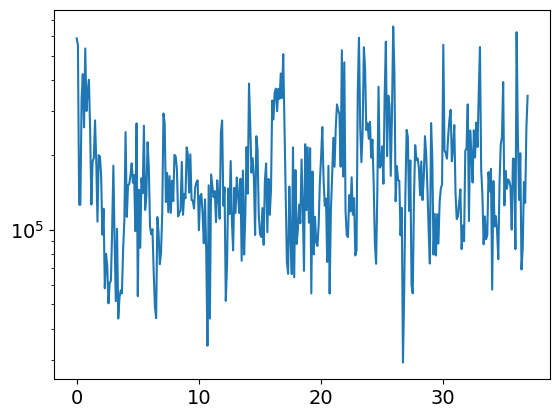

In [26]:
d_sq = []
for i in range(len(task_data_df)):
    d_sq.append(np.sum(np.abs(task_data_df[i]['new_tinyX']-task_data_df[i]['x_imputed'])))

plt.plot(np.arange(len(d_sq))/10,d_sq)
plt.yscale('log')

In [27]:
reaction_time_saccade_asc = []
reaction_time_saccade_tiny = []
countnan = 0


for i in range(len(task_data_df)):
    # if i == 3:

    task_data_df[i] = task_data_df[i].reset_index(drop=True)
    starting_time = task_data_df[i]['t_ms0'].min()
    time_offset_ms = float(task_data_df[i].time_delay[0]) * 1000  # Convert seconds to milliseconds

    index_to_highlight = (task_data_df[i]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()
    # print(index_to_highlight)

    # saccade_start_saccade_asc_1 =np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],len(task_data_df[i])-index_to_highlight)
    # saccade_start_saccade_asc_2 = np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],len(task_data_df[i])-index_to_highlight)
    saccade_start_saccade_asc_1 =np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_asc_2 = np.append( np.where(task_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_asc = np.min(np.hstack([saccade_start_saccade_asc_1,saccade_start_saccade_asc_2]))
    
    
    if (saccade_start_saccade_asc < 10000) and (saccade_start_saccade_asc > 0):
    # if saccade_start_saccade_asc > 0 and saccade_start_saccade_asc < 10000:
        reaction_time_saccade_asc.append(saccade_start_saccade_asc)

    
    saccade_start_saccade_tiny_1 =np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_tiny_2 = np.append( np.where(task_data_df[i]['new_tinyX'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_tiny = np.min(np.hstack([saccade_start_saccade_tiny_1,saccade_start_saccade_tiny_2]))

    if (saccade_start_saccade_tiny > 0) and (saccade_start_saccade_tiny < 10000):
        reaction_time_saccade_tiny.append(saccade_start_saccade_tiny)

    # if len(saccade_start_saccade_asc_1)>1 and len(saccade_start_saccade_asc_2)>1:
    #     print('asc',i)
    # if len(saccade_start_saccade_tiny_1)>1 and len(saccade_start_saccade_tiny_2)>1:
    #     print('tiny',i)

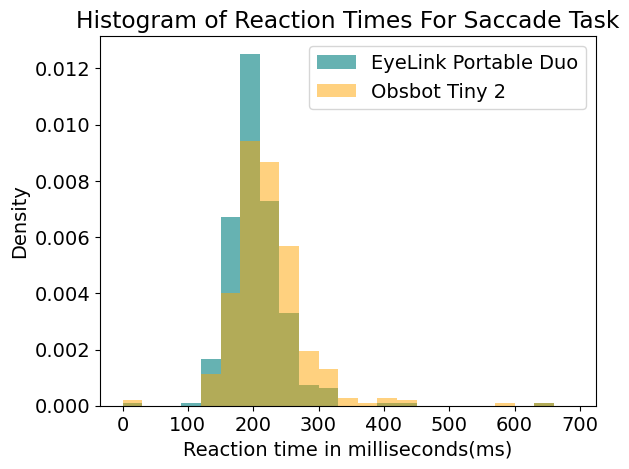

In [28]:
plt.hist(reaction_time_saccade_asc, np.arange(0,700,30), color='teal', density = True, alpha=0.6, label='EyeLink Portable Duo')
plt.hist(reaction_time_saccade_tiny, np.arange(0,700,30), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel('Reaction time in milliseconds(ms)')
plt.title('Histogram of Reaction Times For Saccade Task')
plt.legend()
plt.show()